# **Part (1)**

# **Augmented Reality with Planar Homographies**

**Imports**

In [ ]:
import numpy as np
import cv2 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image

**Loading video and converting it into frames**

In [ ]:
def loadVid(path):
	# Create a VideoCapture object and read from input file
	# If the input is the camera, pass 0 instead of the video file name
	cap = cv2.VideoCapture(path)	 
	# Check if camera opened successfully
	if (cap.isOpened()== False): 
		print("Error opening video stream or file")

	i = 0
	# Read until video is completed
	while(cap.isOpened()):
		# Capture frame-by-frame
		i += 1
		ret, frame = cap.read()
		if ret == True:

			#Store the resulting frame
			if i == 1:
				frames = frame[np.newaxis, ...]
			else:
				frame = frame[np.newaxis, ...]
				frames = np.vstack([frames, frame])
				frames = np.squeeze(frames)
			
		else: 
			break
	# When everything done, release the video capture object
	cap.release()

	return frames

In [ ]:
source_frames = loadVid("/content/ar_source.mov")
book_frames = loadVid("/content/book.mov")

In [ ]:
print(len(book_frames))
print(len(source_frames))

641
511


**Making copies of the book frames to always use the original**

In [ ]:
book_frames_copy1 = book_frames
book_frames_copy2 = np.copy(book_frames_copy1)
book_frames_copy3 = np.copy(book_frames_copy2)

**Loading the book cover image**

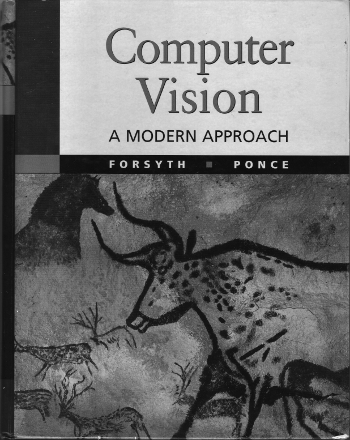

In [ ]:
cv_cover = cv2.imread("/content/cv_cover.jpg")
cv_cover1 = cv2.imread("/content/cv_cover.jpg")
cv2_imshow(cv_cover)

In [ ]:
book_frame1 = book_frames[0]

In [ ]:
book_frame1copy = np.copy(book_frame1)

**Initiate SIFT detector**

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
#getting key points of the book cover
key_points_1, dest1 = sift.detectAndCompute(cv_cover,None)

# **1.1 Getting Correspondences**

In [ ]:
def sift_descriptor(image):
  # Initiate SIFT detector
  sift = cv2.xfeatures2d.SIFT_create()

  # find the keypoints and descriptors with SIFT
  key_points_2, dest2 = sift.detectAndCompute(image,None)
  return key_points_2, dest2

key_points_2, dest2 = sift_descriptor(book_frame1)
print ("Found keypoints in image 1: " + str(len(key_points_1)))
print ("Found keypoints in image 2: " + str(len(key_points_2)))

Found keypoints in image 1: 1205
Found keypoints in image 2: 1842


**Plotting the images with their key points**

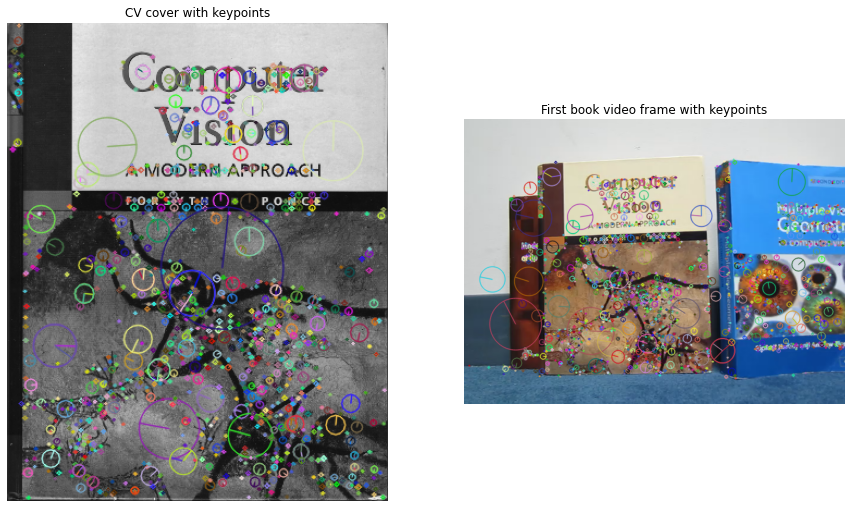

In [ ]:
img1=cv2.drawKeypoints(cv_cover ,
                      key_points_1 ,
                      cv_cover ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2=cv2.drawKeypoints(book_frame1 ,
                      key_points_2 ,
                      book_frame1 ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,15))
ax=ax.flatten()
ax[0].imshow(cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB));
ax[0].title.set_text("CV cover with keypoints");
ax[0].axis("off");
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB));
ax[1].title.set_text("First book video frame with keypoints");
ax[1].axis("off");

**Matching first 50 features in the book cover to their corresponding features in the first book video frame**

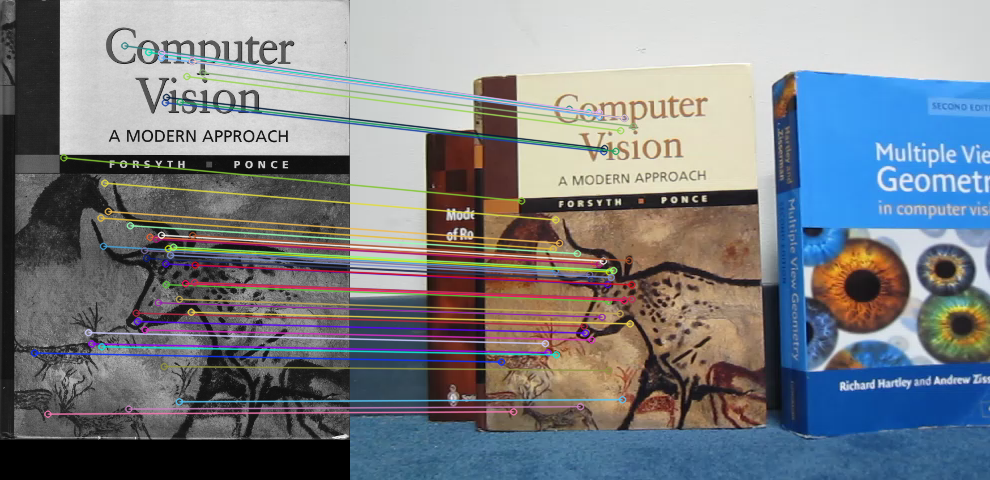

In [ ]:
def feature_matcher(img1, img2, key_points_2, dest2):
  brute_force_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck = False)
  matches = brute_force_matcher.knnMatch(dest1,dest2, k=2)
  good = []
  good_without_list = []
  for m,n in matches:
      if m.distance < 0.3*n.distance:
          good.append([m])
          good_without_list.append(m)

  # cv2.drawMatchesKnn expects list of lists as matches.
  img3 = cv2.drawMatchesKnn(img1,key_points_1,img2,key_points_2,good[:50],img2,flags=2)

  return img3, good_without_list

img3, good_without_list = feature_matcher(cv_cover1, book_frame1copy, key_points_2, dest2)
cv2_imshow(img3)

**Adjusting the key points to calculate homography matrix**

In [ ]:
def key_points_adjust(key_points_2, good_without_list):
  kps_a = []
  kps_b = []
  matches=good_without_list[:100]
  for match in matches:
      # Get the matching keypoints for each of the images
      img_a_idx = match.queryIdx
      img_b_idx = match.trainIdx
      # Get the coordinates
      (x1,y1) = key_points_1[img_a_idx].pt
      (x2,y2) = key_points_2[img_b_idx].pt
      # Append to each list
      kps_a.append((x1, y1))
      kps_b.append((x2, y2))

  kps_a = np.asarray(kps_a)
  kps_b = np.asarray(kps_b)

  return kps_a, kps_b

kps_a, kps_b = key_points_adjust(key_points_2, good_without_list)

# **1.2 Compute the Homography Parameters**

In [ ]:
def get_coordinates(kps,index):
  point = kps[index]
  return point[0] , point[1]
def get_sub_a_matrix(x,y,x_,y_):
  matrix=np.zeros((2,8))
  matrix[0]=np.array([x, y,1,0,0,0, -x*x_, -y*x_])
  matrix[1]=np.array([0,0,0,x, y,1, -x*y_, -y*y_])
  return matrix  
def get_homography_matrix(kps_a,kps_b):
  n=len(kps_a)
  #build b 
  b = np.zeros(((2*n),1))
  for i in range(n):
    b[2*i], b[2*i +1]=get_coordinates(kps_b,i)
  # build a
  a = np.zeros(((2*n),8))
  for i in range(n):
    x,y=get_coordinates(kps_a,i)
    x_,y_=get_coordinates(kps_b,i)
    sub_a_matrix=get_sub_a_matrix(x,y,x_,y_)
    a[2*i] = sub_a_matrix[0]
    a[2*i + 1] = sub_a_matrix[1]		
  # Solve equations to compute H
  H=np.linalg.lstsq(a, b)[0]
  H=np.append(H,1)
  H=np.reshape(H,(3,3))
  return H

calculated_homography_matrix = get_homography_matrix(kps_a,kps_b)
calculated_homography_matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


array([[ 7.76462514e-01,  3.32297921e-03,  1.19080465e+02],
       [-4.99536867e-02,  7.79077152e-01,  7.74073040e+01],
       [-8.65699975e-05, -7.52825569e-05,  1.00000000e+00]])

**Verifying the homography matrix with the built-in function**

In [ ]:
actual_homography_matrix, status = cv2.findHomography(kps_a, kps_b)
actual_homography_matrix

array([[ 7.76809883e-01,  3.43072137e-03,  1.19049263e+02],
       [-4.97410790e-02,  7.79337983e-01,  7.73636259e+01],
       [-8.59083627e-05, -7.49265642e-05,  1.00000000e+00]])

**Getting the corners of the book cover**

In [ ]:
height = cv_cover1.shape[0]
width = cv_cover1.shape[1]

book_corners = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]])

# **1.3 Calculate Book Coordinates**

In [ ]:
def video_book_corners(book_corners, calculated_homography_matrix):
  augment = np.ones((book_corners.shape[0],1))
  projective_book_corners = np.concatenate((book_corners, augment), axis=1).T
  projective_points = calculated_homography_matrix.dot(projective_book_corners)
  target_corners = np.true_divide(projective_points, projective_points[-1])
  vidFrame_book_corners = target_corners[:2].T

  return vidFrame_book_corners

vidFrame_book_corners = video_book_corners(book_corners, calculated_homography_matrix)
vidFrame_book_corners

array([[119.08046543,  77.40730398],
       [124.65911778, 433.75744172],
       [417.96602543, 429.13634843],
       [402.21806873,  61.84189202]])

In [ ]:
book_frame2copy = np.copy(book_frame1copy)

In [ ]:
sourceImageMarker = cv2.polylines(book_frame1copy, [np.int32(vidFrame_book_corners)], True,
                                      255, 5, cv2.LINE_AA)

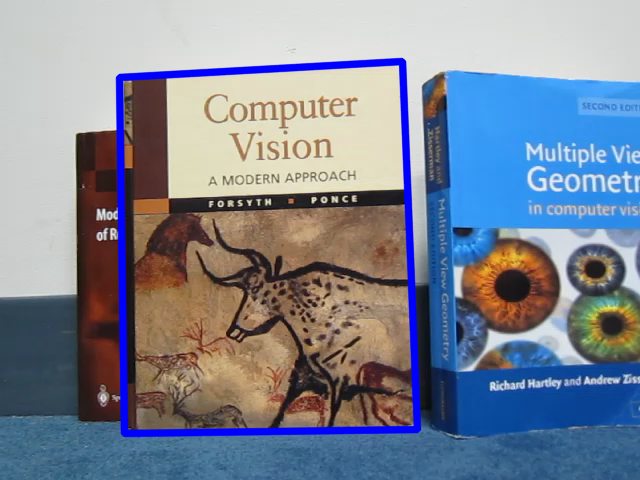

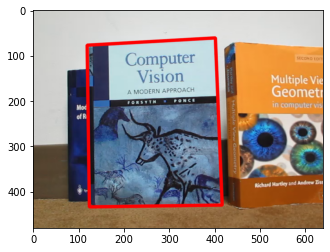

In [ ]:
cv2_imshow(sourceImageMarker)
plt.imshow(sourceImageMarker)

# **1.4 Crop AR Video Frames**

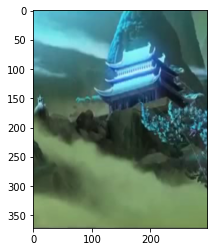

In [ ]:
def crop_source_vid(image, vidFrame_book_corners):
  hs = image.shape[0]
  ws = image.shape[1]

  cropped_src = image[44:,int(ws/3):int((ws*4)/5)]
  cropped_src2 = cropped_src[:272,:]

  target_height = int(vidFrame_book_corners[1][1]) - int(vidFrame_book_corners[3][1])
  target_width = int(vidFrame_book_corners[2][0]) - int(vidFrame_book_corners[0][0])
  if(target_height < 0 or target_width < 0):
    target_dimensions = (0-target_height, 0-target_width)
  else:
    target_dimensions = (target_width, target_height)

  ready_frame = cv2.resize(cropped_src2, target_dimensions)

  return ready_frame

ready_frame = crop_source_vid(source_frames[0], vidFrame_book_corners)
plt.imshow(ready_frame)

# **1.5 Overlay the First Frame of the Two Videos**

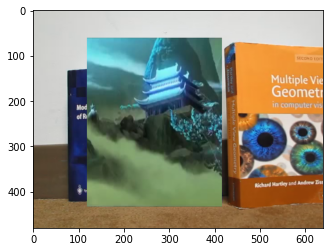

In [ ]:
def overlaying_frames(book_frame, ready_frame, vidFrame_book_corners):
  overlay = Image.fromarray(book_frame)
  ready_frame = np.array(ready_frame)
  ready_frame = Image.fromarray(ready_frame)

  x = int(vidFrame_book_corners[0][0])
  y = int(vidFrame_book_corners[3][1])

  if(x < 0):
    x = x + 5
  if(y < 40 or y > 100):
    y = 85

  overlay.paste(ready_frame, (x, y))

  return overlay

overlayed = overlaying_frames(np.array(book_frame2copy), ready_frame, vidFrame_book_corners)
plt.imshow(overlayed)

# **1.6 Creating AR Application**

In [ ]:
overlayed_frames = []
overlayed_frames.append(overlayed)

for i in range(1,len(source_frames)):
  print(i)
  key_points_2, dest2 = sift_descriptor(book_frames_copy1[i])
  img3, good_without_list = feature_matcher(cv_cover1, book_frames_copy2[i], key_points_2, dest2)
  kps_a, kps_b = key_points_adjust(key_points_2, good_without_list)
  calculated_homography_matrix = get_homography_matrix(kps_a,kps_b)
  vidFrame_book_corners = video_book_corners(book_corners, calculated_homography_matrix)
  print(vidFrame_book_corners)
  ready_frame = crop_source_vid(source_frames[i], vidFrame_book_corners)
  overlayed = overlaying_frames(book_frames_copy3[i], ready_frame, vidFrame_book_corners)

  overlayed_frames.append(overlayed)

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[119.03707653  77.44454074]
 [124.58986173 433.94063504]
 [417.89207985 428.98264458]
 [402.09410377  61.87944953]]
2
[[119.07985541  77.26189338]
 [124.76769476 433.61871369]
 [417.74512317 429.05963716]
 [402.27901705  61.83364381]]
3
[[119.26640131  77.68066092]
 [124.80840418 433.73306055]
 [417.94724141 429.13101045]
 [402.19751304  61.80131811]]
4
[[119.10680681  77.39678536]
 [124.64743373 433.90959369]
 [417.85584859 428.97699025]
 [402.13892371  61.86421952]]
5
[[119.0134492   77.26959753]
 [124.54335335 434.17387128]
 [417.73837644 428.91602884]
 [401.97345394  61.93242278]]
6
[[119.2736739   77.68663823]
 [124.87094437 433.72555633]
 [417.87169725 429.09091224]
 [402.21233594  61.60822085]]
7
[[118.98944887  77.32925275]
 [124.77980988 433.70497377]
 [417.75885393 428.83568751]
 [402.18908042  61.82930134]]
8
[[119.65001983  78.17554684]
 [125.24169848 433.29510949]
 [418.09824239 429.29027097]
 [402.49895501  61.20483452]]
9
[[119.28645799  77.78252311]
 [124.8986117  433.

**Converting the overlayed video frames into a video**

In [ ]:
output = cv2.VideoWriter('ar_video.mov',cv2.VideoWriter_fourcc(*'DIVX'), 15, (book_frames[0].shape[1], book_frames[0].shape[0]))

for i in range(len(overlayed_frames)):
    output.write(np.array(overlayed_frames[i]))
output.release()